In [1]:
import pandas as pd
import os
from scipy import stats
import numpy as np
%matplotlib inline
import seaborn as sb
import matplotlib.pyplot as plt
import dask.dataframe as dd

In [2]:
raw = '../data/raw/'

In [3]:
train = dd.read_csv(raw + 'train.csv')

In [4]:
train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


/anaconda/lib/python3.5/site-packages/dask/async.py:291: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  result = _execute_task(task, data)


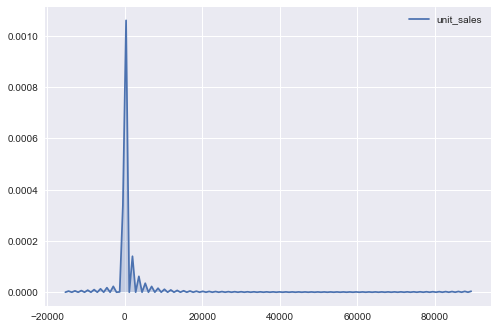

In [5]:
sb.kdeplot(train['unit_sales'], shade=True)

In [6]:
train.describe()

,id,store_nbr,item_nbr,unit_sales,onpromotion
npartitions=1,,,,,
None,int64,int64,int64,float64,float64
None,...,...,...,...,...


In [7]:
panel1 = train[train['unit_sales'] <= -2000]
temp = train[train['unit_sales'] <= 2000]
panel2 = temp[temp['unit_sales'] >= -2000]

In [8]:
temp = train[train['unit_sales'] <= 25]
panel3 = temp[temp['unit_sales'] >= -5]

In [9]:
panel4 = train[train['unit_sales'] >= 20000]

/anaconda/lib/python3.5/site-packages/dask/async.py:291: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  result = _execute_task(task, data)


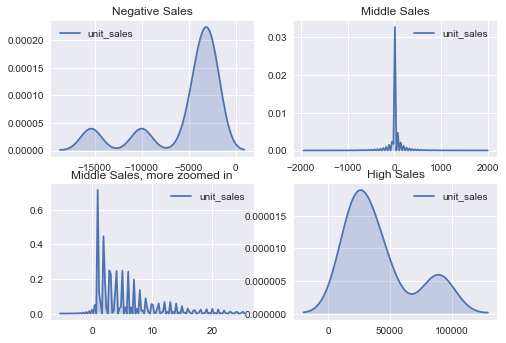

In [10]:
f, ax = plt.subplots(2,2)
sb.kdeplot(panel1['unit_sales'], shade=True, ax = ax[0][0]).set_title('Negative Sales')
sb.kdeplot(panel2['unit_sales'], shade=True, ax = ax[0][1]).set_title('Middle Sales')
sb.kdeplot(panel3['unit_sales'], shade=True, ax = ax[1][0]).set_title('Middle Sales, more zoomed in')
sb.kdeplot(panel4['unit_sales'], shade=True, ax = ax[1][1]).set_title('High Sales')

Bottom line, the unit sales data are highly non-normal. Both very high kurtosis and positive skew.

And of course they aren't "really" continuous since you can't sell .5 of a product!

There also seems to be a weird effect where at very high or very negative numbers only "nice round numbers" are being reported (e.g., spike at 15000, 10000...)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10c0e9240>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10d3f37f0>]], dtype=object)

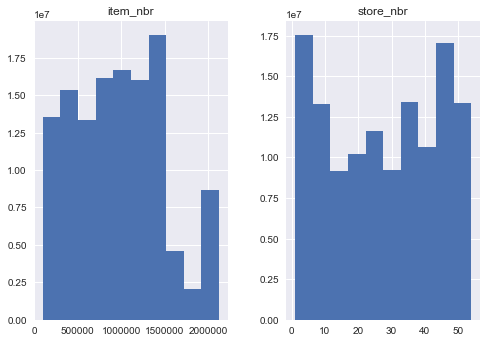

In [11]:
train.hist(column = ['item_nbr', 'store_nbr'])

In [12]:
onpro = train.onpromotion.value_counts()

[None, None, None, None]

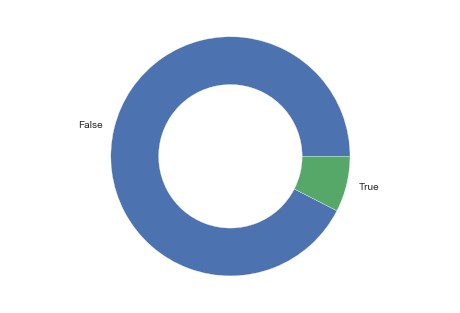

In [13]:
fig, ax = plt.subplots()
ax.axis('equal')
mypie, _ = ax.pie(onpro.values, radius=1, labels=onpro.keys())
plt.setp(mypie, width=0.4, edgecolor='white')

Some items come up more often than others, as do some stores, but no particular pattern.

Way fewer items are on promotion than not.

In [14]:
items = pd.read_csv(raw + 'items.csv')

In [15]:
items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [16]:
family_counts = items.family.value_counts()

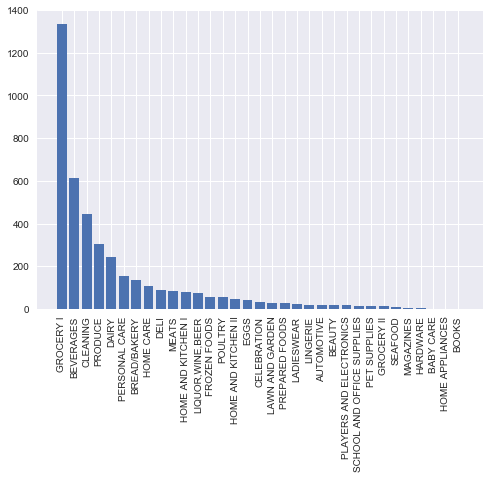

In [17]:
y_pos = np.arange(len(family_counts))
plt.bar(y_pos, family_counts.values)
plt.xticks(y_pos, family_counts.keys(), rotation = 90)
plt.show()

In [18]:
items.columns = ['item_nbr', 'family', 'class_', 'perishable']

In [19]:
#do family and class mean the same thing?
count_table = pd.DataFrame(columns = family_counts.keys(), index = items.class_.unique(), data = 0)

for i in range(0, len(items) -1):
    count_table[items['family'][i]][items['class_'][i]] += 1
    
count_table
#no family and class do not mean the same thing, because then there would only be numbers along
#the diagonal!
#however, there is only one nonzero value per row, in other words a family can contain many
#many classes, but a class cannot be part of multiple families

,GROCERY I,BEVERAGES,CLEANING,PRODUCE,DAIRY,PERSONAL CARE,BREAD/BAKERY,HOME CARE,DELI,MEATS,...,PLAYERS AND ELECTRONICS,SCHOOL AND OFFICE SUPPLIES,PET SUPPLIES,GROCERY II,SEAFOOD,MAGAZINES,HARDWARE,BABY CARE,HOME APPLIANCES,BOOKS
1093,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1067,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3008,0,0,26,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1028,48,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2712,0,0,0,0,0,0,17,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1045,24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1034,98,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1044,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1092,19,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1032,65,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


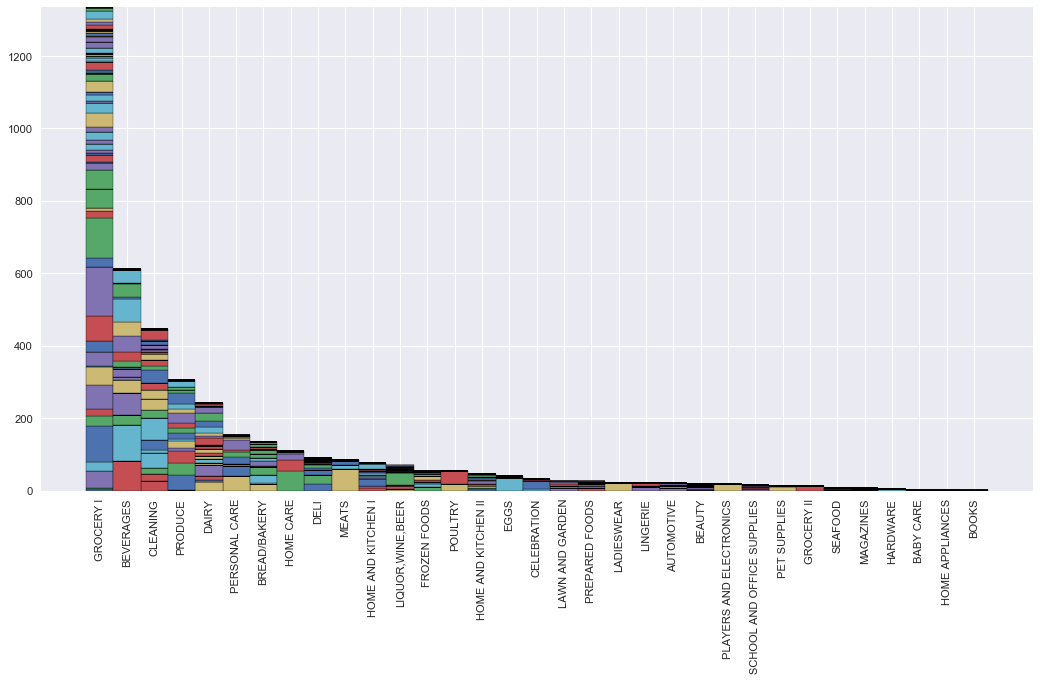

In [20]:
bars = ([0]*len(count_table.columns))
r = np.arange(len(count_table.columns))
names = count_table.columns
plt.figure(figsize=(16,8), dpi = 80)

for i in np.arange(len(count_table)):
    plt.bar(r, count_table.iloc[i][:].values, edgecolor = 'black', bottom = bars, width = 1)
    bars = bars + count_table.iloc[i][:].values

plt.xticks(y_pos, family_counts.keys(), rotation = 90)
plt.show()

In [21]:
#some classes are more common than others, smaller families for the most part have fewer classes
#all makes pretty good sense!

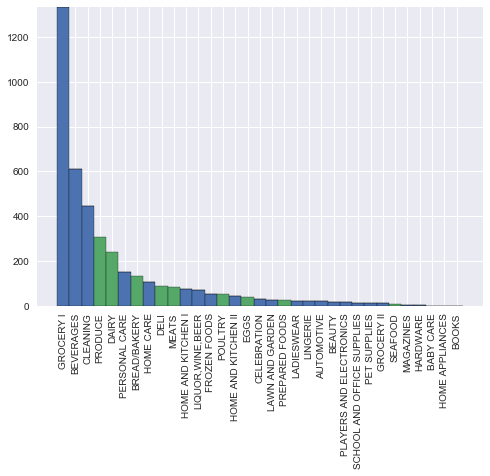

In [22]:
count_perish = pd.DataFrame(columns = family_counts.keys(), index = items.perishable.unique(), data = 0)

for i in range(0, len(items) -1):
    count_perish[items['family'][i]][items['perishable'][i]] += 1
    
#stacked bar graph, how many perishable in each family?
bars = ([0]*len(count_perish.columns))
r = np.arange(len(count_perish.columns))
names = count_perish.columns
#plt.figure(figsize=(16,8), dpi = 80)

for i in np.arange(len(count_perish)):
    plt.bar(r, count_perish.iloc[i][:].values, edgecolor = 'black', bottom = bars, width = 1)
    bars = bars + count_perish.iloc[i][:].values

plt.xticks(y_pos, family_counts.keys(), rotation = 90)
plt.show()

In [23]:
count_perish

,GROCERY I,BEVERAGES,CLEANING,PRODUCE,DAIRY,PERSONAL CARE,BREAD/BAKERY,HOME CARE,DELI,MEATS,...,PLAYERS AND ELECTRONICS,SCHOOL AND OFFICE SUPPLIES,PET SUPPLIES,GROCERY II,SEAFOOD,MAGAZINES,HARDWARE,BABY CARE,HOME APPLIANCES,BOOKS
0,1334,613,446,0,0,153,0,108,0,0,...,17,15,14,14,0,6,4,1,1,1
1,0,0,0,306,242,0,134,0,91,84,...,0,0,0,0,8,0,0,0,0,0


So major takeways...
* a given family is either perishable or not
* a class can only belong to one family
* family and perishable may be redundant with class, though I could imagine perishability having a big influence, but would modelling perishability explictly be silly if we already model class so that variability will be sucked up by class

In [3]:
holidays = pd.read_csv(raw + 'holidays_events.csv')

In [6]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [7]:
holitype = holidays.type.value_counts()

[None, None, None, None, None, None, None, None, None, None, None, None]

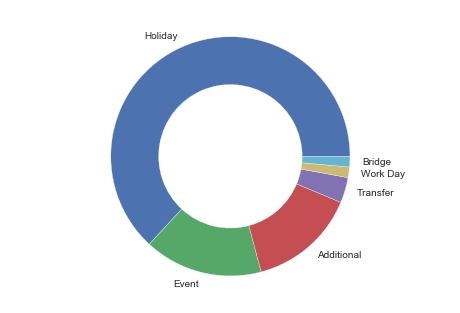

In [8]:
fig, ax = plt.subplots()
ax.axis('equal')
mypie, _ = ax.pie(holitype.values, radius=1, labels=holitype.keys())
plt.setp(mypie, width=0.4, edgecolor='white')

In [10]:
locale_counts = holidays.locale.value_counts()

locale_count_table = pd.DataFrame(columns = locale_counts.keys(), index = holidays.locale_name.unique(), data = 0)

for i in range(0, len(holidays) -1):
    locale_count_table[holidays['locale'][i]][holidays['locale_name'][i]] += 1
    
locale_count_table

,National,Local,Regional
Manta,0,6,0
Cotopaxi,0,0,6
Cuenca,0,7,0
Libertad,0,6,0
Riobamba,0,12,0
Puyo,0,6,0
Guaranda,0,12,0
Imbabura,0,0,6
Latacunga,0,12,0
Machala,0,6,0


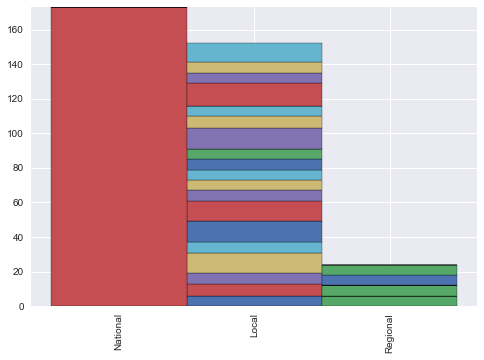

In [12]:
#again, locale_name can only belong to one locale (national, local, or regional), but locale's 
#have multiple locale names

#stacked bar graph, how many perishable in each family?
bars = ([0]*len(locale_count_table.columns))
r = np.arange(len(locale_count_table.columns))
names = locale_count_table.columns
#plt.figure(figsize=(16,8), dpi = 80)

for i in np.arange(len(locale_count_table)):
    plt.bar(r, locale_count_table.iloc[i][:].values, edgecolor = 'black', bottom = bars, width = 1)
    bars = bars + locale_count_table.iloc[i][:].values

plt.xticks(r, locale_count_table.columns, rotation = 90)
plt.show()

In [14]:
holitrans = holidays.transferred.value_counts()

[None, None, None, None]

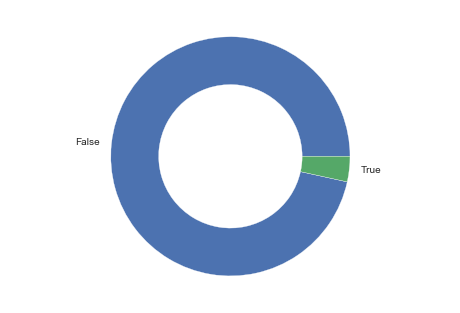

In [15]:
fig, ax = plt.subplots()
ax.axis('equal')
mypie, _ = ax.pie(holitrans.values, radius=1, labels=holitrans.keys())
plt.setp(mypie, width=0.4, edgecolor='white')

In [16]:
type_table = pd.DataFrame(columns = holitype.keys(), index = holitrans.keys(), data = 0)

for i in range(0, len(holidays) -1):
    type_table[holidays['type'][i]][holidays['transferred'][i]] += 1
    
type_table

,Holiday,Event,Additional,Transfer,Work Day,Bridge
False,209,56,50,12,5,5
True,12,0,0,0,0,0


In [17]:
#okay, only holidays can be transferred, also, transfers are quite rare

In [11]:
oil = pd.read_csv(raw + 'oil.csv')

In [12]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [13]:
stores = pd.read_csv(raw + 'stores.csv')

In [14]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [15]:
transactions = pd.read_csv(raw + 'transactions.csv')

In [16]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
